# Neural Network for CLA Project

### Import statements

In [111]:
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import Constants

### Hyperparameters

In [296]:
# data processing
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
batch_size = 100    # batch size for the DataLoaders

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 100                # multiplied by num_features to determine the size of each hidden layer
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer
num_epochs = 100                # number of epochs

### Read in data

In [297]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set = "data_2017_summer"

# if dest_path does not exist, create it
if not os.path.exists(dest_path):
    try:
        os.makedirs(dest_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to -1, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1
        
# order data set
# no_alg_set_x = np.zeros(shape=(1, 17))
# no_alg_set_y = np.zeros(shape=1)
# alg_set_x = np.zeros(shape=(1, 17))
# alg_set_y = np.zeros(shape=1)

# for i in range(0, len(y)):
#     if y[i] == 0:
#         no_alg_set_x = np.append(no_alg_set_x, np.reshape(X[i, :], newshape=(1, num_features)), axis=0)
#         no_alg_set_y = np.append(no_alg_set_y, y[i])
#     else:
#         alg_set_x = np.append(alg_set_x, np.reshape(X[i, :], newshape=(1, num_features)), axis=0)
#         alg_set_y = np.append(alg_set_y, y[i])
        
# no_alg_set_x = np.delete(no_alg_set_x, obj=0, axis=0)
# no_alg_set_y = np.delete(no_alg_set_y, obj=0)
# alg_set_x = np.delete(alg_set_x, obj=0, axis=0)
# alg_set_y = np.delete(alg_set_y, obj=0)

# X = np.append(no_alg_set_x, alg_set_x, axis=0)
# y = np.append(no_alg_set_y, alg_set_y)

### Process and split data set

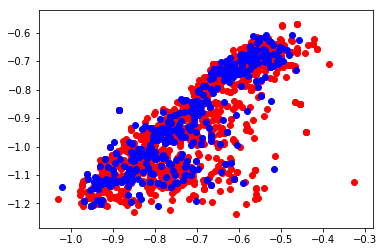

In [298]:
# standardize data: remove the mean and variance in each sample

# TEST DATA DELETE THIS
# num_test_samples = 47000
# X = 100*np.random.rand(num_test_samples, num_features)
# y = np.random.randint(2, size=num_test_samples);
# X1 = np.random.randn(1000, num_features)
# X2 = np.random.randn(1000, num_features) + 1.5
# X = np.concatenate((X1, X2), axis=0)
# y1 = np.zeros(shape=(1000, 1))
# y2 = np.ones(shape=(1000, 1))
# y = np.concatenate((y1, y2), axis=0)
# plt.scatter(X1[:, 0], X1[:, 1], color='b')
# plt.scatter(X2[:, 0], X2[:, 1], color='r')





num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)
# X_train = preprocessing.normalize(X_train, norm="l2", axis=1) # Attempted normalization rather than standardization
# X_test = preprocessing.normalize(X_test, norm="l2", axis=1)

# convert numpy arrays to pytorch tensors
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=batch_size, shuffle=True)

plt.scatter(X_train[:, 0], X_train[:, 1], color="r")
plt.scatter(X_test[:, 0], X_test[:, 1], color="b")

### Define neural network model

In [299]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)   # change to hidden_size
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.relu4 = nn.ReLU()
#         self.fc5 = nn.Linear(hidden_size, hidden_size)
#         self.relu5 = nn.ReLU()
#         self.fc6 = nn.Linear(hidden_size, hidden_size)
#         self.relu6 = nn.ReLU()
#         self.fc7 = nn.Linear(hidden_size, hidden_size)
#         self.relu7 = nn.ReLU()
#         self.fc8 = nn.Linear(hidden_size, hidden_size)
#         self.relu8 = nn.ReLU()
#         self.fc9 = nn.Linear(hidden_size, hidden_size)
#         self.relu9 = nn.ReLU()
#         self.fc10 = nn.Linear(hidden_size, hidden_size)
#         self.relu10 = nn.ReLU()
#         self.fc11 = nn.Linear(hidden_size, hidden_size)
#         self.relu11 = nn.ReLU()
#         self.fc12 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
#         out = self.relu2(out)
#         out = self.fc3(out)
#         out = self.relu3(out)
#         out = self.fc4(out)
#         out = self.relu4(out)
#         out = self.fc5(out)
#         out = self.relu5(out)
#         out = self.fc6(out)
#         out = self.relu6(out)
#         out = self.fc7(out)
#         out = self.relu7(out)
#         out = self.fc8(out)
#         out = self.relu8(out)
#         out = self.fc9(out)
#         out = self.relu9(out)
#         out = self.fc10(out)
#         out = self.relu10(out)
#         out = self.fc11(out)
#         out = self.relu11(out)
#         out = self.fc12(out)
        out = self.sig1(out)
        return out

### Instantiate the neural network

In [300]:
model = CLANet(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=1, dampening=0)
model.double();     # cast model parameters to double

### Train the neural network

In [302]:
model.train()     # training mode
training_loss = []
avg_error = 0

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = model(samples)                # forward pass
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights

#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(name, param.data)
        
        # calculate and print error
        out = output

        for i in range(0, out.size()[0]):
            if out[i] < 0.5:
                out[i] = 0
            else:
                out[i] = 1
        error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        avg_error += error
        training_loss.append(loss.data.numpy())
#         print("  Iteration: %d/%d, Error: %0.4f, Loss: %g" % 
#               (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), error, loss.item()))
        print("  Iteration: %d/%d, Loss: %g, Error: %0.4f" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item(), error))
    
    print("Average Error for this Epoch: %0.4f" % (avg_error / np.ceil(X_train.size()[0] / batch_size)))
    avg_error = 0

Epoch: 1/100
  Iteration: 100/17, Loss: 0.490007, Error: 0.2200
  Iteration: 100/17, Loss: 0.598534, Error: 0.3100
  Iteration: 100/17, Loss: 0.545451, Error: 0.2500
  Iteration: 100/17, Loss: 0.530581, Error: 0.2500
  Iteration: 100/17, Loss: 0.555693, Error: 0.3200
  Iteration: 100/17, Loss: 0.613859, Error: 0.3300
  Iteration: 100/17, Loss: 0.502969, Error: 0.2700
  Iteration: 100/17, Loss: 0.553605, Error: 0.2600
  Iteration: 100/17, Loss: 0.519885, Error: 0.2500
  Iteration: 100/17, Loss: 0.626631, Error: 0.3400
  Iteration: 100/17, Loss: 0.594113, Error: 0.2700
  Iteration: 100/17, Loss: 0.522923, Error: 0.2400
  Iteration: 100/17, Loss: 0.584817, Error: 0.2700
  Iteration: 100/17, Loss: 0.497538, Error: 0.2200
  Iteration: 100/17, Loss: 0.553661, Error: 0.3000
  Iteration: 100/17, Loss: 0.634525, Error: 0.3000
  Iteration: 62/17, Loss: 0.531833, Error: 0.2581
Average Error for this Epoch: 0.2740
Epoch: 2/100
  Iteration: 100/17, Loss: 0.596673, Error: 0.2700
  Iteration: 100/17,

  Iteration: 100/17, Loss: 0.580141, Error: 0.2700
  Iteration: 100/17, Loss: 0.514816, Error: 0.2300
  Iteration: 100/17, Loss: 0.483227, Error: 0.2000
  Iteration: 100/17, Loss: 0.534604, Error: 0.2400
  Iteration: 100/17, Loss: 0.486476, Error: 0.2100
  Iteration: 100/17, Loss: 0.514448, Error: 0.2600
  Iteration: 100/17, Loss: 0.577622, Error: 0.2900
  Iteration: 100/17, Loss: 0.529198, Error: 0.2700
  Iteration: 100/17, Loss: 0.499883, Error: 0.2100
  Iteration: 100/17, Loss: 0.618436, Error: 0.3300
  Iteration: 100/17, Loss: 0.53293, Error: 0.2600
  Iteration: 100/17, Loss: 0.585212, Error: 0.2800
  Iteration: 100/17, Loss: 0.622815, Error: 0.3000
  Iteration: 62/17, Loss: 0.598735, Error: 0.3226
Average Error for this Epoch: 0.2590
Epoch: 11/100
  Iteration: 100/17, Loss: 0.507731, Error: 0.2300
  Iteration: 100/17, Loss: 0.48525, Error: 0.2500
  Iteration: 100/17, Loss: 0.570499, Error: 0.2900
  Iteration: 100/17, Loss: 0.547626, Error: 0.2700
  Iteration: 100/17, Loss: 0.53827

  Iteration: 100/17, Loss: 0.568678, Error: 0.2300
  Iteration: 100/17, Loss: 0.490309, Error: 0.2300
  Iteration: 62/17, Loss: 0.469211, Error: 0.1935
Average Error for this Epoch: 0.2649
Epoch: 20/100
  Iteration: 100/17, Loss: 0.598214, Error: 0.3100
  Iteration: 100/17, Loss: 0.4736, Error: 0.2400
  Iteration: 100/17, Loss: 0.488978, Error: 0.2300
  Iteration: 100/17, Loss: 0.622361, Error: 0.3400
  Iteration: 100/17, Loss: 0.603691, Error: 0.2900
  Iteration: 100/17, Loss: 0.579315, Error: 0.3100
  Iteration: 100/17, Loss: 0.570734, Error: 0.2500
  Iteration: 100/17, Loss: 0.548443, Error: 0.2900
  Iteration: 100/17, Loss: 0.539532, Error: 0.2800
  Iteration: 100/17, Loss: 0.483284, Error: 0.2200
  Iteration: 100/17, Loss: 0.475556, Error: 0.2200
  Iteration: 100/17, Loss: 0.50638, Error: 0.2400
  Iteration: 100/17, Loss: 0.452798, Error: 0.1800
  Iteration: 100/17, Loss: 0.538746, Error: 0.2500
  Iteration: 100/17, Loss: 0.566173, Error: 0.3000
  Iteration: 100/17, Loss: 0.504652

  Iteration: 100/17, Loss: 0.599766, Error: 0.2500
  Iteration: 100/17, Loss: 0.576458, Error: 0.3100
  Iteration: 62/17, Loss: 0.431112, Error: 0.2419
Average Error for this Epoch: 0.2625
Epoch: 30/100
  Iteration: 100/17, Loss: 0.447635, Error: 0.1900
  Iteration: 100/17, Loss: 0.557466, Error: 0.2900
  Iteration: 100/17, Loss: 0.523789, Error: 0.2300
  Iteration: 100/17, Loss: 0.551937, Error: 0.2800
  Iteration: 100/17, Loss: 0.561037, Error: 0.2700
  Iteration: 100/17, Loss: 0.583341, Error: 0.2600
  Iteration: 100/17, Loss: 0.449673, Error: 0.1900
  Iteration: 100/17, Loss: 0.646337, Error: 0.3500
  Iteration: 100/17, Loss: 0.495208, Error: 0.2600
  Iteration: 100/17, Loss: 0.434812, Error: 0.1800
  Iteration: 100/17, Loss: 0.609793, Error: 0.2800
  Iteration: 100/17, Loss: 0.527869, Error: 0.2200
  Iteration: 100/17, Loss: 0.543675, Error: 0.2800
  Iteration: 100/17, Loss: 0.484015, Error: 0.2700
  Iteration: 100/17, Loss: 0.564467, Error: 0.3100
  Iteration: 100/17, Loss: 0.549

  Iteration: 100/17, Loss: 0.494721, Error: 0.2000
  Iteration: 100/17, Loss: 0.538291, Error: 0.2600
  Iteration: 100/17, Loss: 0.447933, Error: 0.1500
  Iteration: 100/17, Loss: 0.523259, Error: 0.2500
  Iteration: 100/17, Loss: 0.403402, Error: 0.2000
  Iteration: 100/17, Loss: 0.55549, Error: 0.2400
  Iteration: 100/17, Loss: 0.53376, Error: 0.2400
  Iteration: 62/17, Loss: 0.489292, Error: 0.2419
Average Error for this Epoch: 0.2554
Epoch: 40/100
  Iteration: 100/17, Loss: 0.569932, Error: 0.2800
  Iteration: 100/17, Loss: 0.557223, Error: 0.2400
  Iteration: 100/17, Loss: 0.547398, Error: 0.3100
  Iteration: 100/17, Loss: 0.435373, Error: 0.1700
  Iteration: 100/17, Loss: 0.484437, Error: 0.2200
  Iteration: 100/17, Loss: 0.507704, Error: 0.2600
  Iteration: 100/17, Loss: 0.554278, Error: 0.2600
  Iteration: 100/17, Loss: 0.540369, Error: 0.3200
  Iteration: 100/17, Loss: 0.566854, Error: 0.3100
  Iteration: 100/17, Loss: 0.503492, Error: 0.2700
  Iteration: 100/17, Loss: 0.51308

  Iteration: 100/17, Loss: 0.480715, Error: 0.2300
  Iteration: 100/17, Loss: 0.567187, Error: 0.2200
  Iteration: 100/17, Loss: 0.482131, Error: 0.2400
  Iteration: 100/17, Loss: 0.482645, Error: 0.2300
  Iteration: 100/17, Loss: 0.4971, Error: 0.2000
  Iteration: 100/17, Loss: 0.515992, Error: 0.2500
  Iteration: 100/17, Loss: 0.415973, Error: 0.1800
  Iteration: 100/17, Loss: 0.518547, Error: 0.2600
  Iteration: 100/17, Loss: 0.415463, Error: 0.1800
  Iteration: 100/17, Loss: 0.61363, Error: 0.2900
  Iteration: 62/17, Loss: 0.51293, Error: 0.1935
Average Error for this Epoch: 0.2349
Epoch: 50/100
  Iteration: 100/17, Loss: 0.487509, Error: 0.1800
  Iteration: 100/17, Loss: 0.570265, Error: 0.2400
  Iteration: 100/17, Loss: 0.593962, Error: 0.3000
  Iteration: 100/17, Loss: 0.390679, Error: 0.1300
  Iteration: 100/17, Loss: 0.579623, Error: 0.2700
  Iteration: 100/17, Loss: 0.590486, Error: 0.2500
  Iteration: 100/17, Loss: 0.573631, Error: 0.3000
  Iteration: 100/17, Loss: 0.518562,

  Iteration: 100/17, Loss: 0.385641, Error: 0.1500
  Iteration: 100/17, Loss: 0.553864, Error: 0.2500
  Iteration: 100/17, Loss: 0.47756, Error: 0.2500
  Iteration: 100/17, Loss: 0.548616, Error: 0.2700
  Iteration: 100/17, Loss: 0.438788, Error: 0.2100
  Iteration: 100/17, Loss: 0.542305, Error: 0.2600
  Iteration: 100/17, Loss: 0.402149, Error: 0.1400
  Iteration: 100/17, Loss: 0.551395, Error: 0.2300
  Iteration: 100/17, Loss: 0.451637, Error: 0.1900
  Iteration: 100/17, Loss: 0.54156, Error: 0.2200
  Iteration: 100/17, Loss: 0.486026, Error: 0.2300
  Iteration: 100/17, Loss: 0.595866, Error: 0.2600
  Iteration: 62/17, Loss: 0.58584, Error: 0.2903
Average Error for this Epoch: 0.2277
Epoch: 60/100
  Iteration: 100/17, Loss: 0.457237, Error: 0.2500
  Iteration: 100/17, Loss: 0.472662, Error: 0.2800
  Iteration: 100/17, Loss: 0.409659, Error: 0.1400
  Iteration: 100/17, Loss: 0.519467, Error: 0.2600
  Iteration: 100/17, Loss: 0.470357, Error: 0.1600
  Iteration: 100/17, Loss: 0.569735

  Iteration: 100/17, Loss: 0.590482, Error: 0.2800
  Iteration: 100/17, Loss: 0.490885, Error: 0.2900
  Iteration: 100/17, Loss: 0.499386, Error: 0.2100
  Iteration: 100/17, Loss: 0.420969, Error: 0.2200
  Iteration: 100/17, Loss: 0.585674, Error: 0.2700
  Iteration: 100/17, Loss: 0.475964, Error: 0.2200
  Iteration: 100/17, Loss: 0.514289, Error: 0.3100
  Iteration: 100/17, Loss: 0.546192, Error: 0.2600
  Iteration: 100/17, Loss: 0.46657, Error: 0.2100
  Iteration: 100/17, Loss: 0.475484, Error: 0.2100
  Iteration: 62/17, Loss: 0.475151, Error: 0.2419
Average Error for this Epoch: 0.2460
Epoch: 70/100
  Iteration: 100/17, Loss: 0.429507, Error: 0.2100
  Iteration: 100/17, Loss: 0.48233, Error: 0.2400
  Iteration: 100/17, Loss: 0.574107, Error: 0.2900
  Iteration: 100/17, Loss: 0.516741, Error: 0.2900
  Iteration: 100/17, Loss: 0.493409, Error: 0.3300
  Iteration: 100/17, Loss: 0.500999, Error: 0.2300
  Iteration: 100/17, Loss: 0.487735, Error: 0.2100
  Iteration: 100/17, Loss: 0.48088

  Iteration: 100/17, Loss: 0.554099, Error: 0.3100
  Iteration: 100/17, Loss: 0.458741, Error: 0.2200
  Iteration: 100/17, Loss: 0.514809, Error: 0.2500
  Iteration: 62/17, Loss: 0.377312, Error: 0.1935
Average Error for this Epoch: 0.2284
Epoch: 80/100
  Iteration: 100/17, Loss: 0.527354, Error: 0.2500
  Iteration: 100/17, Loss: 0.459371, Error: 0.2200
  Iteration: 100/17, Loss: 0.405473, Error: 0.1700
  Iteration: 100/17, Loss: 0.503606, Error: 0.2100
  Iteration: 100/17, Loss: 0.438112, Error: 0.1700
  Iteration: 100/17, Loss: 0.48465, Error: 0.2400
  Iteration: 100/17, Loss: 0.459522, Error: 0.2500
  Iteration: 100/17, Loss: 0.48467, Error: 0.2100
  Iteration: 100/17, Loss: 0.567843, Error: 0.3000
  Iteration: 100/17, Loss: 0.492059, Error: 0.2400
  Iteration: 100/17, Loss: 0.463305, Error: 0.2200
  Iteration: 100/17, Loss: 0.478745, Error: 0.2400
  Iteration: 100/17, Loss: 0.526511, Error: 0.2000
  Iteration: 100/17, Loss: 0.539602, Error: 0.2500
  Iteration: 100/17, Loss: 0.50707

  Iteration: 100/17, Loss: 0.503384, Error: 0.2000
  Iteration: 100/17, Loss: 0.500256, Error: 0.2900
  Iteration: 100/17, Loss: 0.528293, Error: 0.2000
  Iteration: 100/17, Loss: 0.30397, Error: 0.1500
  Iteration: 100/17, Loss: 0.634369, Error: 0.3600
  Iteration: 100/17, Loss: 0.55561, Error: 0.2700
  Iteration: 100/17, Loss: 0.491726, Error: 0.2400
  Iteration: 62/17, Loss: 0.655004, Error: 0.3226
Average Error for this Epoch: 0.2237
Epoch: 90/100
  Iteration: 100/17, Loss: 0.477037, Error: 0.2100
  Iteration: 100/17, Loss: 0.391104, Error: 0.1800
  Iteration: 100/17, Loss: 0.406826, Error: 0.1600
  Iteration: 100/17, Loss: 0.557088, Error: 0.2800
  Iteration: 100/17, Loss: 0.422397, Error: 0.1900
  Iteration: 100/17, Loss: 0.360687, Error: 0.1600
  Iteration: 100/17, Loss: 0.492964, Error: 0.2000
  Iteration: 100/17, Loss: 0.491509, Error: 0.2300
  Iteration: 100/17, Loss: 0.600292, Error: 0.3100
  Iteration: 100/17, Loss: 0.463168, Error: 0.2200
  Iteration: 100/17, Loss: 0.44194

  Iteration: 100/17, Loss: 0.466292, Error: 0.2300
  Iteration: 100/17, Loss: 0.514951, Error: 0.2200
  Iteration: 100/17, Loss: 0.532779, Error: 0.2400
  Iteration: 100/17, Loss: 0.507589, Error: 0.3100
  Iteration: 100/17, Loss: 0.394593, Error: 0.1500
  Iteration: 100/17, Loss: 0.564652, Error: 0.2600
  Iteration: 100/17, Loss: 0.447698, Error: 0.1900
  Iteration: 100/17, Loss: 0.321795, Error: 0.1300
  Iteration: 62/17, Loss: 0.568757, Error: 0.2742
Average Error for this Epoch: 0.2061
Epoch: 100/100
  Iteration: 100/17, Loss: 0.45155, Error: 0.1800
  Iteration: 100/17, Loss: 0.436272, Error: 0.1900
  Iteration: 100/17, Loss: 0.375614, Error: 0.1500
  Iteration: 100/17, Loss: 0.483397, Error: 0.2100
  Iteration: 100/17, Loss: 0.446832, Error: 0.1700
  Iteration: 100/17, Loss: 0.42553, Error: 0.2000
  Iteration: 100/17, Loss: 0.474136, Error: 0.2100
  Iteration: 100/17, Loss: 0.526836, Error: 0.2900
  Iteration: 100/17, Loss: 0.494903, Error: 0.2100
  Iteration: 100/17, Loss: 0.4229

In [289]:
out = output

for i in range(0, out.size()[0]):
    if out[i] < 0.5:
        out[i] = 0
    else:
        out[i] = 1
out

tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 1.], dtype=torch.float64,
       grad_fn=<AsStridedBackward>)

In [251]:
labels

tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 1.], dtype=torch.float64)